This notebooks aims to compare SD1.5-based and Kolors model which is based on the Heatmob pipeline

In [3]:
import os
import gc

from diffusers import (
    StableDiffusionControlNetInpaintPipeline,
    ControlNetModel,
    EulerDiscreteScheduler,
)
from diffusers.models import AutoencoderKL
from diffusers.utils import load_image, make_image_grid
import torch
import numpy as np
import PIL
from controlnet_aux import OpenposeDetector
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

from kolors.pipelines.pipeline_stable_diffusion_xl_chatglm_256_inpainting import StableDiffusionXLInpaintPipeline
from kolors.models.modeling_chatglm import ChatGLMModel
from kolors.models.tokenization_chatglm import ChatGLMTokenizer
from kolors.models.unet_2d_condition import UNet2DConditionModel

from src.conf import get_project_root

Load Images

In [24]:
ROOT_PATH = get_project_root()

test_dir = os.path.join(ROOT_PATH, 'images', 'test')
cond_img = load_image(os.path.join(test_dir, 'condition_image.png'))
mask_img = load_image(os.path.join(test_dir, 'mask_image.png'))
model_img = load_image(os.path.join(test_dir, 'model_image.png'))

print('======= SHAPE CHECK =======')
print(f'condition image: {np.array(cond_img).shape}')
print(f'mask image: {np.array(mask_img).shape}')
print(f'model image: {np.array(model_img).shape}')

assert isinstance(cond_img, PIL.Image.Image)
assert isinstance(mask_img, PIL.Image.Image)
assert isinstance(model_img, PIL.Image.Image)

======= SHAPE CHECK =======
condition image: (1024, 768, 3)
mask image: (1024, 768, 3)
model image: (1024, 768, 3)


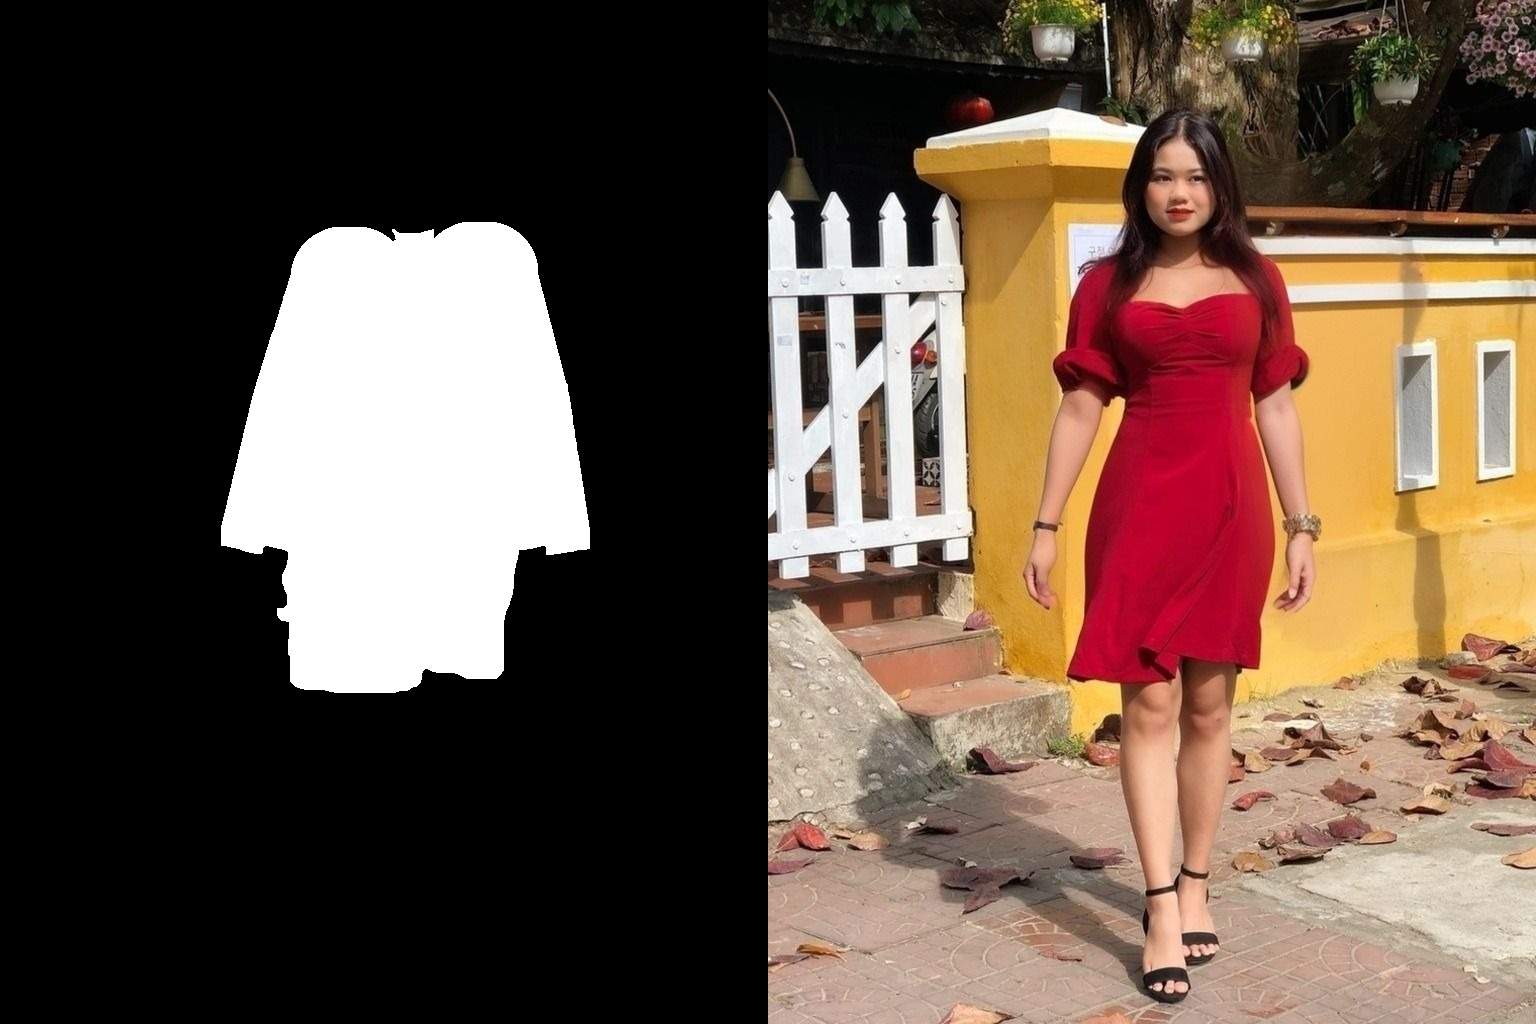

In [15]:
make_image_grid([mask_img, model_img], rows=1, cols=2)

Extract pose

In [7]:
pose_detector = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
pose_img = pose_detector(model_img).resize(model_img.size)
pose_img

SD1.5-based model - cyberrealistic_v40-inpainting.safetensors

In [5]:
try:
    # Load pose ControlNet
    pose_controlnet = ControlNetModel.from_pretrained(
        'lllyasviel/sd-controlnet-openpose',
        torch_dtype=torch.float16,
        use_safetensors=True
    )

    # Load vae
    vae = AutoencoderKL.from_pretrained(
        'pt-sk/sd-vae-ft-ema',
        torch_dtype=torch.float16,
        use_safetensors=True
    )

    # Load pipeline
    model_path = os.path.join(ROOT_PATH, 'downloads', 'cyberrealistic_v40_inpainting.safetensors')
    sd_pipeline = StableDiffusionControlNetInpaintPipeline.from_single_file(
        model_path,
        controlnet=pose_controlnet,
        vae=vae,
        variants='fp16',
        torch_dtype=torch.float16,
        use_safetensors=True,
    ).to('cuda')

    # Change the scheduler
    sd_pipeline.scheduler = EulerDiscreteScheduler.from_config(sd_pipeline.scheduler.config)

    # Load IP-Adapter for conditioning on given outfit
    sd_pipeline.load_ip_adapter(
        'h94/IP-Adapter',
        subfolder='models',
        weight_name='ip-adapter_sd15.bin'
    )
    sd_pipeline.set_ip_adapter_scale(1.) # scale = 1    
    

    # Generation Parameters
    seed = torch.Generator(device='cuda').manual_seed(2024)
    strength = 1.
    cfg_scale = 7. # classifier-free guidance scale
    denoising_steps = 20

    prompt = "8k wallpaper, (best quality:1.2), (extremely detailed:1.3), intricate, masterpiece, \
    (realistic:1.3), ultra realistic, (Masterpiece:1.1), Light blue striped blouse with a bow collar, \
    ruffled hem, long sleeves, paired with white lace-trimmed ruffled shorts."

    negative_prompt = "((tits)), (creased cloth:1.5), ((muscle)), ((shining cloth)), illustration, 3d, 2d, \
    painting, cartoons, anime, sketch, (worst quality:2), (low quality:2), (nomal quality:2), lowres, \
    bad anatomy, bad hand, deformed hands,poorly drawn hands, deformed fingers,weird fingers"
except RuntimeError as e:
    # release cuda memory
    del sd_pipeline
    del vae
    del pose_controlnet
    del sd_pipeline.scheduler
    gc.collect()
    torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/workspace/playground/dev-venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 19.32it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all pub

100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


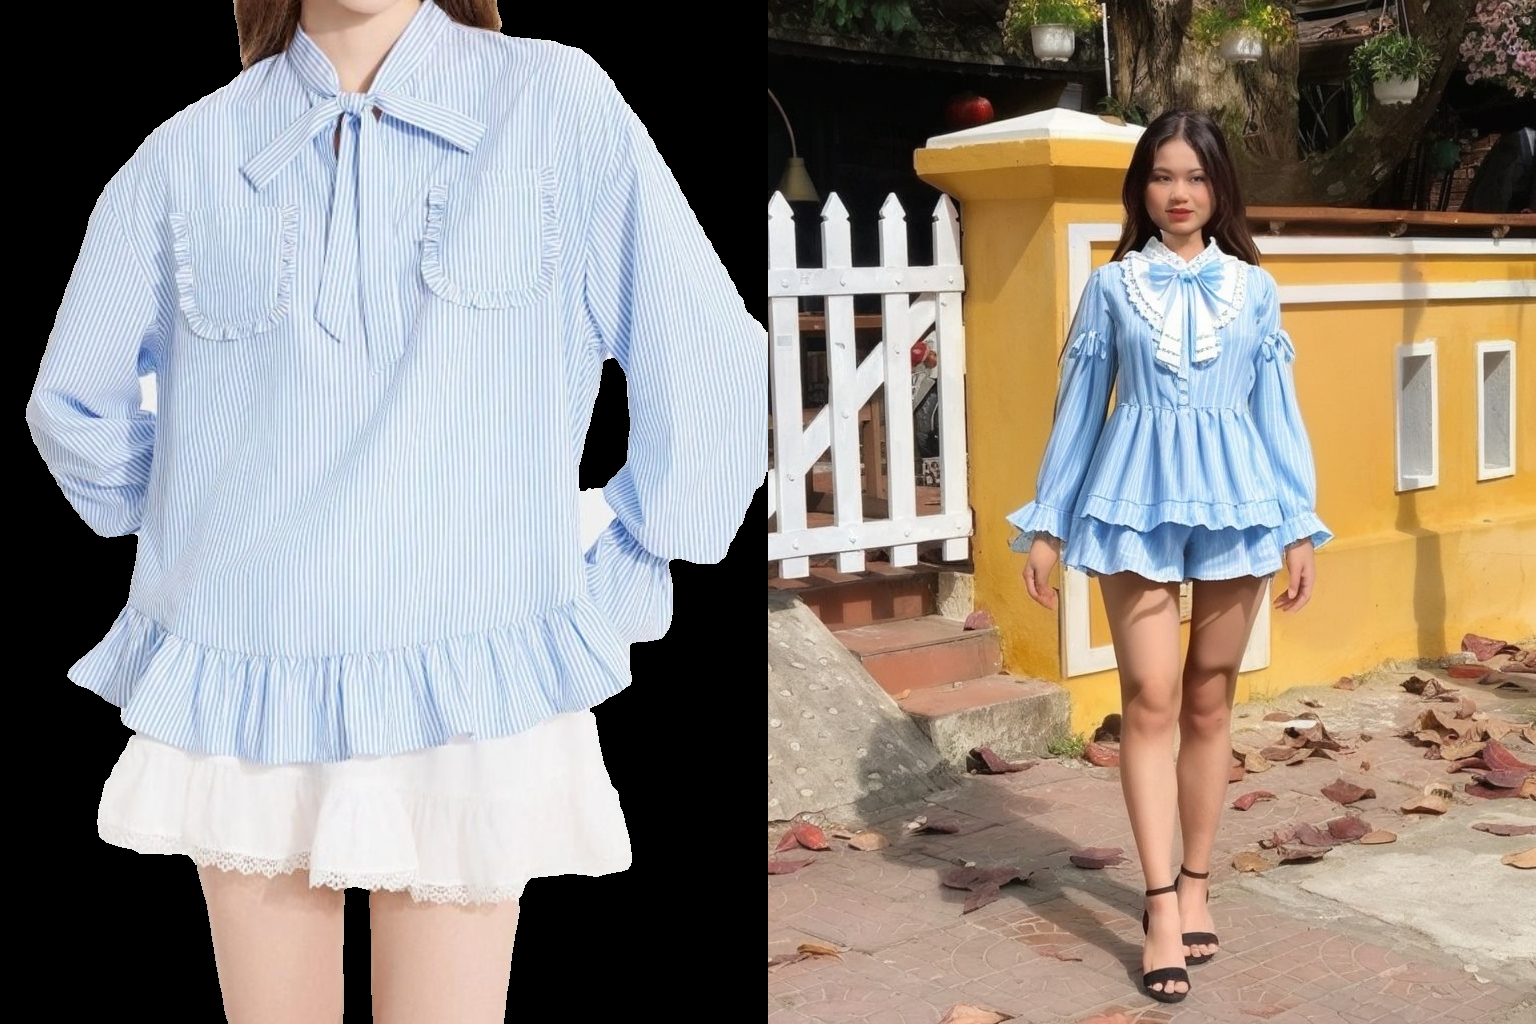

In [6]:
# Generation
sd_output = sd_pipeline(
    image=model_img,
    ip_adapter_image=cond_img,
    mask_image=mask_img,
    control_image=pose_img,
    prompt=prompt,
    negative=prompt,
    strength=strength,
    num_inference_steps=denoising_steps,
    guidance_scale=cfg_scale,
    generator=seed,
).images[0]

make_image_grid([cond_img, sd_output], rows=1, cols=2)

Heatmob pipeline with Kolors model

In [31]:
kolors_ckpt_dir = os.path.join(get_project_root(), 'downloads', 'Kolors-Inpainting')

# Load components
text_encoder = ChatGLMModel.from_pretrained(
    f'{kolors_ckpt_dir}/text_encoder',
    torch_dtype=torch.float16
)
tokenizer = ChatGLMTokenizer.from_pretrained(
    f'{kolors_ckpt_dir}/tokenizer',
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained(
    f'{kolors_ckpt_dir}/vae',
    torch_dtype=torch.float16
)
scheduler = EulerDiscreteScheduler.from_pretrained(
    f'{kolors_ckpt_dir}/scheduler',
    torch_dtype=torch.float16
)
unet = UNet2DConditionModel.from_pretrained(
    f'{kolors_ckpt_dir}/unet',
    torch_dtype=torch.float16
)

# Image encoder for combining with IP-Adapter later
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    f'{get_project_root()}/downloads/Kolors-IP-Adapter-Plus/image_encoder',
    ignore_mismatched_sizes=True,
    torch_dtype=torch.float16
)
ip_image_size = 336
clip_image_processor = CLIPImageProcessor(size=ip_image_size, crop_size=ip_image_size)


kolors_pipeline = StableDiffusionXLInpaintPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    image_encoder=image_encoder, # we use pretrained image encoder from IP-Adapter for the effectiveness
    feature_extractor=clip_image_processor,
).to('cuda')
kolors_pipeline.enable_model_cpu_offload()


# Load IP-Adapter weights
# This below line is suck
if hasattr(kolors_pipeline.unet, 'encoder_hid_proj'):
    kolors_pipeline.unet.text_encoder_hid_proj = kolors_pipeline.unet.encoder_hid_proj

kolors_pipeline.load_ip_adapter(
    f'{get_project_root()}/downloads/Kolors-IP-Adapter-Plus',
    subfolder='',
    weight_name='ip_adapter_plus_general.bin',
)
kolors_pipeline.set_ip_adapter_scale(1.)


# Generation Parameters
seed = torch.Generator(device='cuda').manual_seed(2024)
cfg_scale = 5.
denoising_steps = 25
strength = 1.
height = 1024
width = 768


prompt = "8k wallpaper, (best quality:1.2), (extremely detailed:1.3), intricate, masterpiece, \
(realistic:1.3), ultra realistic, (Masterpiece:1.1), Light blue striped blouse with a bow collar, \
ruffled hem, long sleeves, paired with white lace-trimmed ruffled shorts."

negative_prompt = "((tits)), (creased cloth:1.5), ((muscle)), ((shining cloth)), illustration, 3d, 2d, \
painting, cartoons, anime, sketch, (worst quality:2), (low quality:2), (nomal quality:2), lowres, \
bad anatomy, bad hand, deformed hands,poorly drawn hands, deformed fingers,weird fingers"

100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


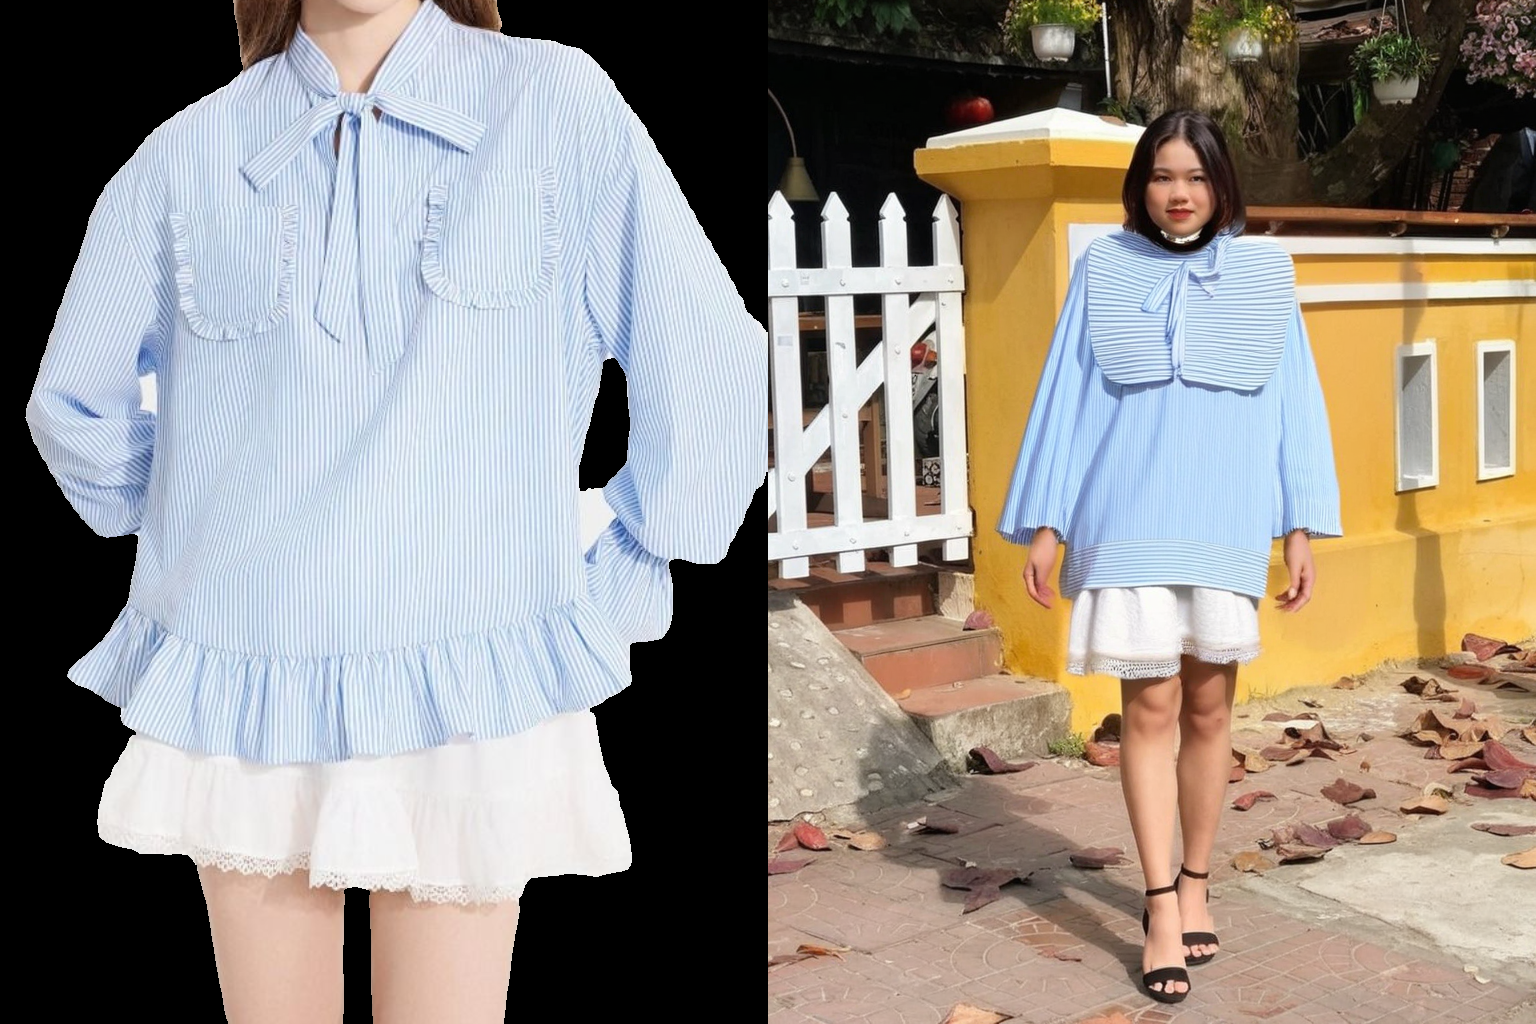

In [32]:
kolors_output = kolors_pipeline(
    image=model_img,
    mask_image=mask_img,
    ip_adapter_image=cond_img,
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=cfg_scale,
    generator=seed,
    num_inference_steps=denoising_steps,
    strength=strength,
    width=width,
    height=height,
).images[0]

make_image_grid([cond_img, kolors_output], rows=1, cols=2)